<a href="https://colab.research.google.com/github/ajayrfhp/LearningDeepLearning/blob/main/ResnetWithStochasticDepth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install d2l

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import copy
from torch.utils.data import RandomSampler
import numpy as np
import torchvision

device_type = 'cpu'
if torch.cuda.is_available():
  device_type = 'cuda'

device = torch.device(device_type)
device

device(type='cuda')

## Resnet

- Simply making a more expressive model does not guarantee a better model unless expressive model includes smaller model in its function landscape

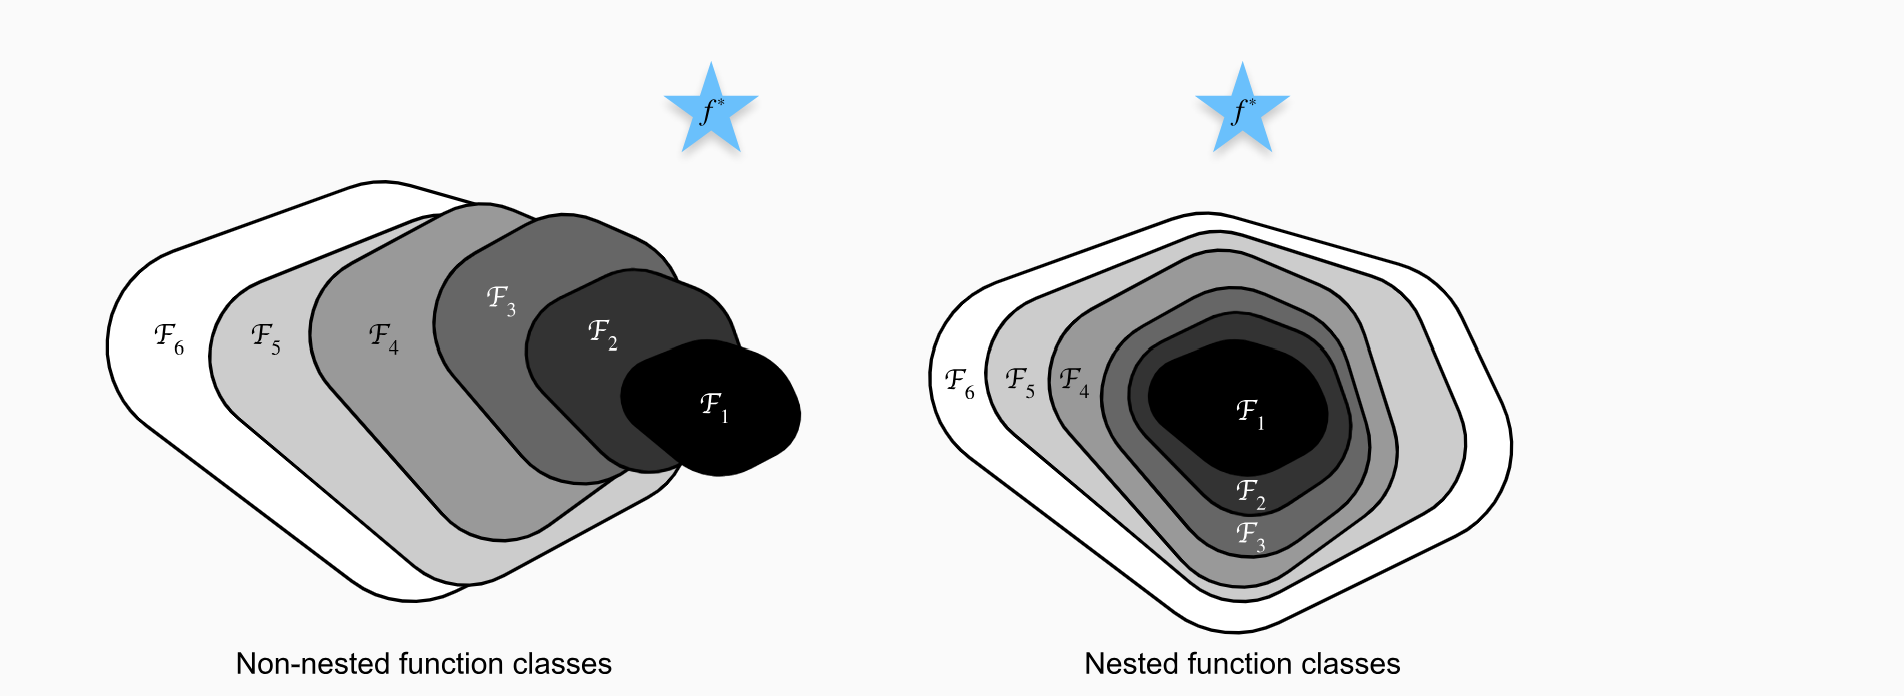

- Resblock

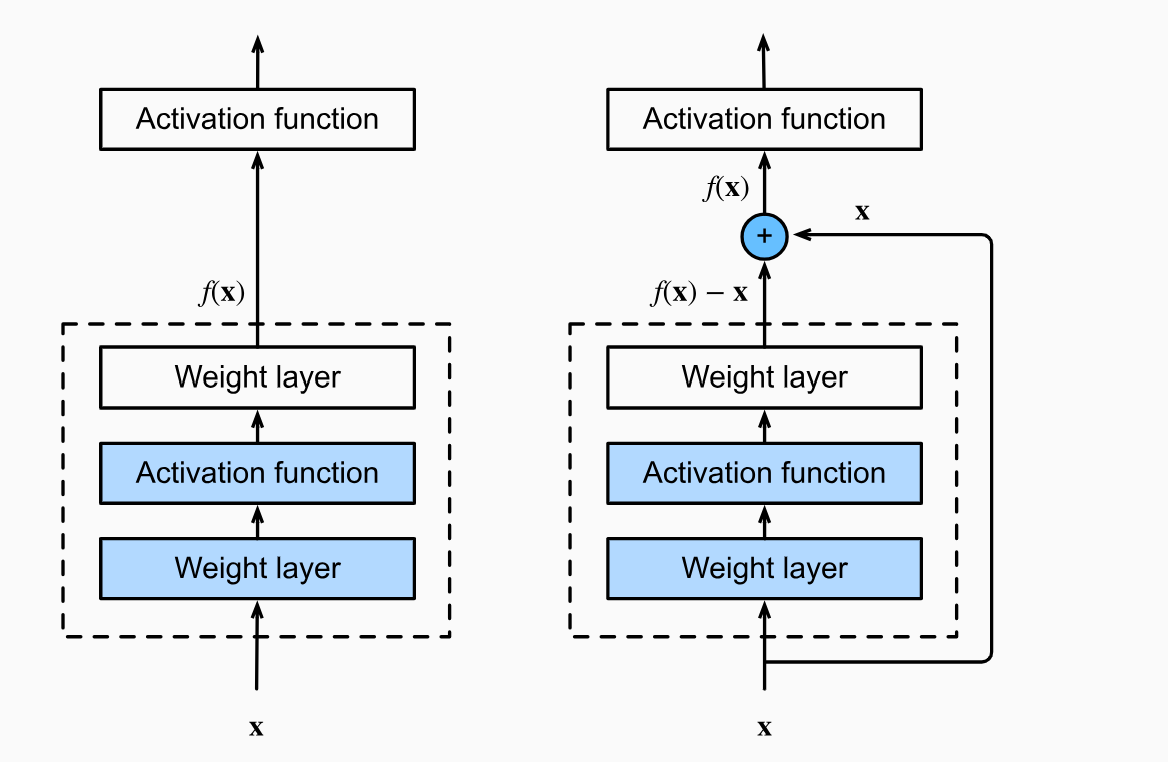

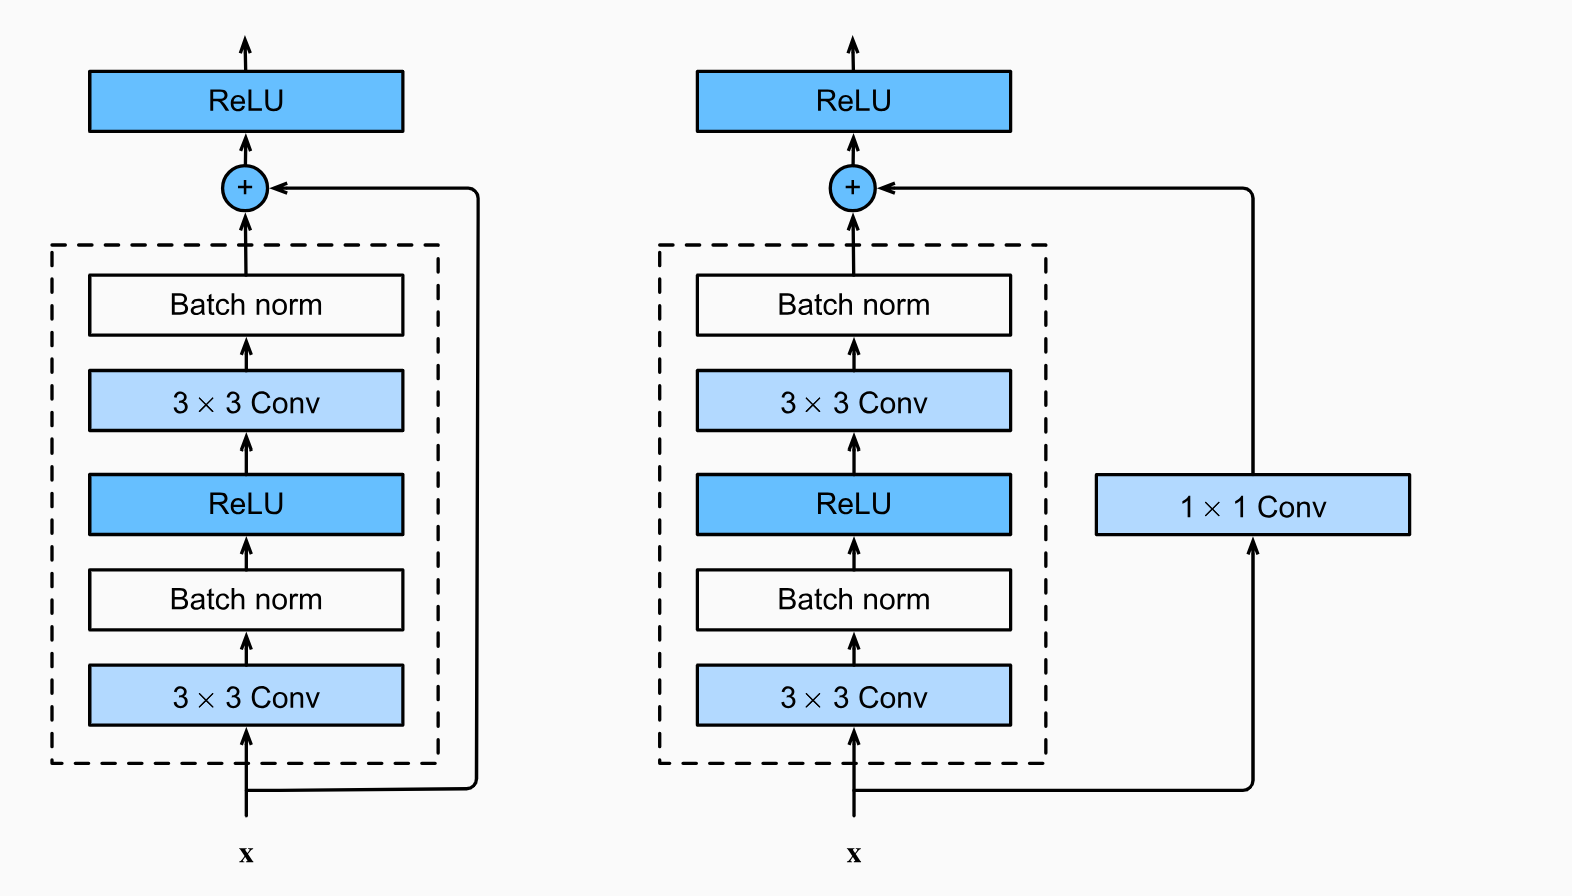


In [ ]:
class ResblockWithStochasticDepth(nn.Module):
  def __init__(self, input_channels, output_channels, stride=1, drop_out_prob=0.5) -> None:
    super(ResblockWithStochasticDepth, self).__init__()
    self.conv1 = nn.Conv2d(input_channels, output_channels, kernel_size=3, stride=stride, padding=1)
    self.bn1 = nn.BatchNorm2d(output_channels)
    self.conv2 = nn.Conv2d(output_channels, output_channels, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(output_channels)

    self.conv3 = nn.Conv2d(input_channels, output_channels, kernel_size=3, stride=stride, padding=1)
    self.stochastic_depth = torchvision.ops.StochasticDepth(p=drop_out_prob, mode='row')
    self.input_channels = input_channels
    self.output_channels = output_channels

  def forward(self, x):
    out = self.conv1(x)
    out = self.bn1(out)
    out = F.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out = F.relu(out)

    if self.input_channels != self.output_channels:
      x = self.conv3(x)
    return F.relu(self.stochastic_depth(out) + x)


res_block = ResblockWithStochasticDepth(1, 64, stride=2)
dummy_input = torch.randn(1, 1, 224, 224)
res_block(dummy_input).shape

torch.Size([1, 64, 112, 112])

In [ ]:
def init_cnn(module):
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class Resnet(d2l.Classifier):
  def __init__(self, num_classes=10, lr=0.1) -> None:
    super(Resnet, self).__init__()

    bottleneck = nn.Sequential(*[
      nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
      nn.BatchNorm2d(64),
      nn.ReLU()],
      nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )
    self.lr = lr

    self.net = nn.Sequential(*[
      bottleneck,

      ResblockWithStochasticDepth(64, 64),
      ResblockWithStochasticDepth(64, 64),

      ResblockWithStochasticDepth(64, 128, stride=2),
      ResblockWithStochasticDepth(128, 128),

      ResblockWithStochasticDepth(128, 256, stride=2),
      ResblockWithStochasticDepth(256, 256),

      ResblockWithStochasticDepth(256, 512, stride=2),
      ResblockWithStochasticDepth(512, 512),

      ResblockWithStochasticDepth(512, 512),


      nn.AdaptiveAvgPool2d(1),
      nn.Flatten(),
      nn.Linear(512, 10)
    ])

  def forward(self, x):
    return self.net.forward(x)

  def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    total_params = 0
    for layer in self.net:
      X = layer(X)
      params = sum([p.numel() for p in layer.parameters()])
      print(layer.__class__.__name__, "output shape = ", X.shape, "Mparams = ", params/1e6)
      total_params += params
    print("Total params In M = ", total_params / (1e6))

res_net = Resnet()
dummy_input = torch.randn(1, 1, 224, 224)
res_net.layer_summary(dummy_input.shape)

Sequential output shape =  torch.Size([1, 64, 56, 56]) Mparams =  0.003328
ResblockWithStochasticDepth output shape =  torch.Size([1, 64, 56, 56]) Mparams =  0.11104
ResblockWithStochasticDepth output shape =  torch.Size([1, 64, 56, 56]) Mparams =  0.11104
ResblockWithStochasticDepth output shape =  torch.Size([1, 128, 28, 28]) Mparams =  0.295808
ResblockWithStochasticDepth output shape =  torch.Size([1, 128, 28, 28]) Mparams =  0.443264
ResblockWithStochasticDepth output shape =  torch.Size([1, 256, 14, 14]) Mparams =  1.18144
ResblockWithStochasticDepth output shape =  torch.Size([1, 256, 14, 14]) Mparams =  1.771264
ResblockWithStochasticDepth output shape =  torch.Size([1, 512, 7, 7]) Mparams =  4.722176
ResblockWithStochasticDepth output shape =  torch.Size([1, 512, 7, 7]) Mparams =  7.081472
ResblockWithStochasticDepth output shape =  torch.Size([1, 512, 7, 7]) Mparams =  7.081472
AdaptiveAvgPool2d output shape =  torch.Size([1, 512, 1, 1]) Mparams =  0.0
Flatten output shape = 

In [ ]:
class SampleFashionMNIST(d2l.FashionMNIST):
  def __init__(self, batch_size, resize=(28, 28)) -> None:
    super(SampleFashionMNIST, self).__init__(batch_size, resize)

  def get_dataloader(self, train, num_samples=1000):
    data = self.train if train else self.val
    random_sampler = RandomSampler(data, num_samples=num_samples)
    return torch.utils.data.DataLoader(data, self.batch_size,
                                           num_workers=self.num_workers, sampler=random_sampler)

training_data = d2l.FashionMNIST(batch_size=400, resize=(224, 224))
testing_data = d2l.FashionMNIST(batch_size=40, resize=(224, 224))
sample_mnist = SampleFashionMNIST(batch_size=256)
sample_mnist.get_dataloader(train=True, num_samples=1)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


- Test that resnet overfits on a small enough dataset

In [ ]:
def train_resnet(data, max_epochs=10):
  trainer = d2l.Trainer(max_epochs=max_epochs, num_gpus=1)
  res_net = Resnet(lr=0.05)
  res_net.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
  trainer.fit(res_net, data)
  return res_net

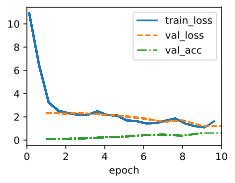

In [ ]:
_ = train_resnet(sample_mnist)

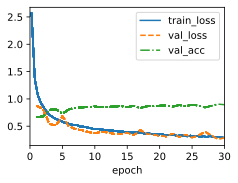

In [ ]:
def get_loss(model, data):
  model.train = False

  losses, access = [], []
  for (inputs, outputs) in data.val_dataloader():
    preds = model.forward(inputs.to(device))
    loss = model.loss(preds, outputs.to(device)).item()
    acc = model.accuracy(preds, outputs.to(device)).item()
    losses.append(loss)
    access.append(acc)

  return np.mean(np.array(losses)), np.mean(np.array(access))

resnet = train_resnet(training_data, max_epochs=30)

In [ ]:
get_loss(resnet, testing_data)